(2866, 2944)

Hue=0
Saturation=199557446
Lightness =0
Hue=0
Saturation=0
Value  =199557446
2922.015443785271
0.018977478100960368
(5731, 5887)
Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 2944)]            0         
                                                                 
 dense_18 (Dense)            (None, 64)                188480    
                                                                 
 dense_19 (Dense)            (None, 2944)              191360    
                                                                 
Total params: 379,840
Trainable params: 379,840
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
6/6 [==============================] - 1s 18ms/step - loss: 18267.3418
Epoch 2/100
6/6 [==============================] - 0s 18ms/step - loss: 18257.5098
Epoch 3/

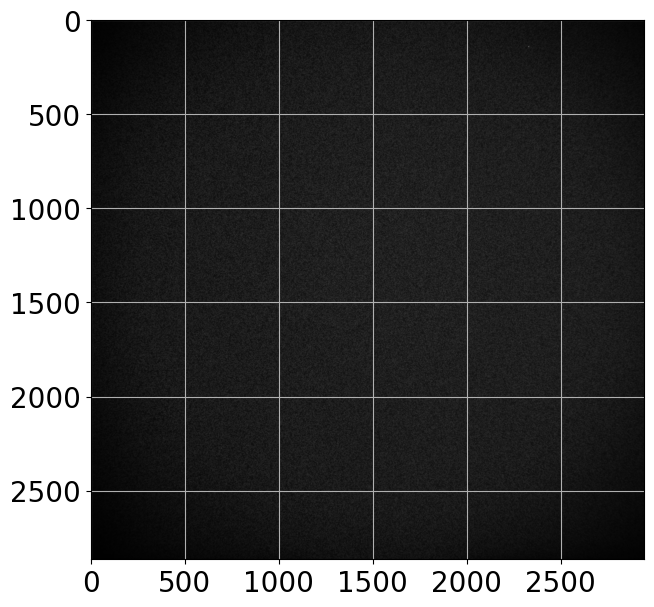

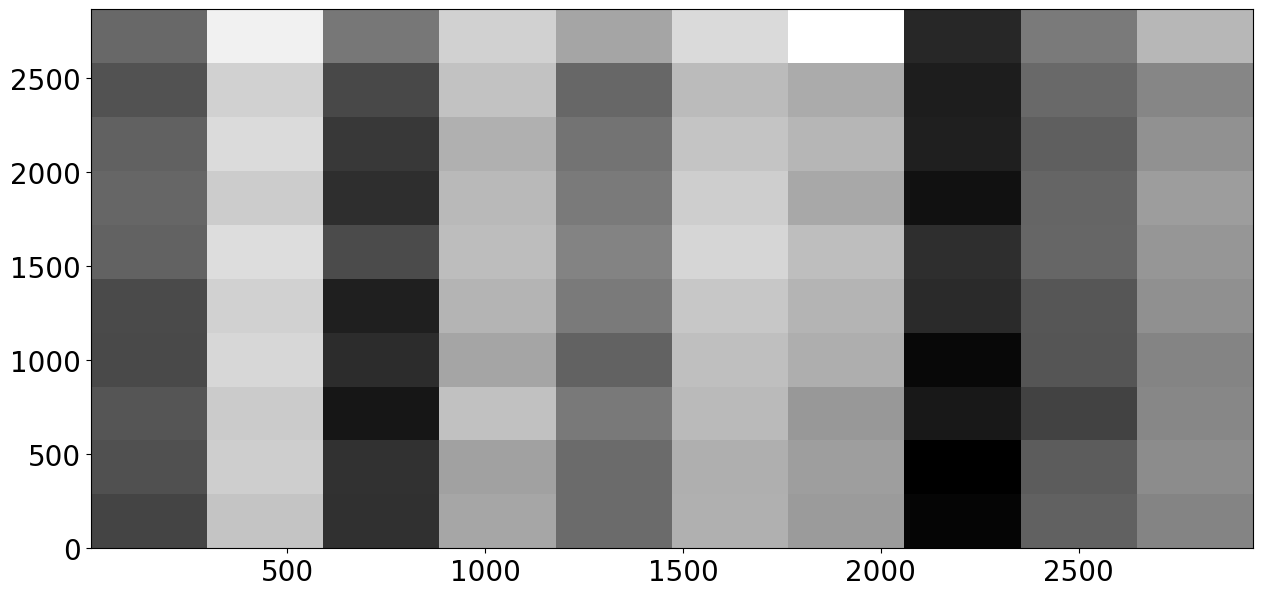

In [10]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
#from libtiff import TIFF
from skimage import io
#import pytiff
from tifffile import tifffile
#import OpenImageIO as oiio
#import rasterio
#import tensorflow_io as tfio
import cv2
import scipy
import keras
from skimage import color, data, restoration
from scipy.signal import convolve2d
import sporco
import skimage 
from scipy import ndimage
from skimage import measure
import matlab
import matlab.engine 
from wolframclient.evaluation import WolframLanguageSession
from wolframclient.language import wl
from wolframclient.language import wl, wlexpr
from wolframclient.evaluation import WolframLanguageSession 
#import htmlPy
import eel
from skimage.metrics import structural_similarity
from skimage.metrics import mean_squared_error
from skimage import filters
from skimage.filters import try_all_threshold
from skimage import morphology
import pandas as pd
from pyclesperanto_prototype import imshow
import pyclesperanto_prototype as cle
from skimage.io import imread



def generate_feature_stack(image):
    # determine features
    blurred = filters.gaussian(image, sigma=2)
    edges = filters.sobel(blurred)

    # collect features in a stack
    # The ravel() function turns a nD image into a 1-D image.
    # We need to use it because scikit-learn expects values in a 1-D format here. 
    feature_stack = [
        image.ravel(),
        blurred.ravel(),
        edges.ravel()
    ]
    
    # return stack as numpy-array
    return np.asarray(feature_stack)

def adjust_gamma(image, gamma=1.0):
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255
        for i in np.arange(0, 256)]).astype("uint8")

    return cv2.LUT(image, table)


def gamma_trans(img,gamma):
    # Конкретный метод сначала нормализуется до 1, а затем гамма используется в качестве значения индекса, чтобы найти новое значение пикселя, а затем восстановить
    gamma_table = [np.power(x/255.0,gamma)*255.0 for x in range(256)]
    gamma_table = np.round(np.array(gamma_table)).astype(np.uint8)
    # Реализация сопоставления использует функцию поиска в таблице Opencv
    return cv2.LUT(img0,gamma_table)


def laplacian_of_gaussian(image, sigma):
    """
    Applies a Gaussian kernel to an image and the Laplacian afterwards.
    """
    
    # blur the image using a Gaussian kernel
    intermediate_result = filters.gaussian(image, sigma)
    
    # apply the mexican hat filter (Laplacian)
    result = filters.laplace(intermediate_result)
    
    return result


def readimage(path):
    'path to file'
    'чтение файла возвращает изображение'
    image = cv2.imread(path,0)
    image=np.asarray(image,dtype=np.uint8)
    return image


def filtration(image,path):
    'path to file correlate'
    'image filtration'
    'фильтрация возвращает фильтрованное изображение'
    
    image=scipy.signal.wiener(image,noise=image.std())
    
    
    image=np.asarray(image,dtype=np.uint8)
    image=cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
    image= cv2.bilateralFilter(image,1,1,1)
    cv2.imwrite("C:/Users/evgen/Downloads/s_1_1102_c_wiener.jpg",image)
    slp,hlp=sporco.signal.tikhonov_filter(image,2)
    hlp=ndimage.median_filter(hlp, size=7)
    hlp=hlp<np.percentile(hlp, 95)
    image2 = readimage(path)
    image2=np.asarray(image2,dtype=np.uint8)
    mse = mean_squared_error(hlp, image2)
    ssim = structural_similarity(hlp, image2, data_range=image2.max() - image2.min())
    print(mse)
    print(ssim)
    eng = matlab.engine.start_matlab()   
    r=eng.corr2(hlp,image2)
    hlp=hlp-hlp.mean()-r*image2
    
    
    hlpfilt=np.asarray(hlp,dtype=np.uint8)
    #hlpfilt = eng.imadjust(hlpfilt,eng.stretchlim(hlpfilt),[])
    hlpfilt=eng.imadjust(hlpfilt)
    hlpfilt=np.asarray(hlpfilt,dtype=np.uint8)
    hlpfilt=cv2.cvtColor(hlpfilt,cv2.COLOR_GRAY2RGB)
    #hlp=scipy.ndimage.percentile_filter(hlp,95)
    
    cv2.imwrite("C:/Users/evgen/Downloads/s_1_1102_cfilt.jpg",hlpfilt)
    #cv2.imwrite("C:/Users/Евгений/Downloads/s_1_1102_cfilt.jpg",hlpfilt)
    r=eng.normxcorr2(hlp,image2)
    r=np.asarray(r,dtype=np.uint8)
    print(r.shape)
    r=cv2.cvtColor(r, cv2.COLOR_GRAY2BGR) 
    cv2.imwrite("C:/Users/evgen/Downloads/s_1_1102_c_a_normxcorr2.jpg",r)
    #cv2.imwrite("C:/Users/Евгений/Downloads/s_1_1102_c_a_normxcorr2.jpg",r)
    eng.quit()
    hlpfilt=cv2.cvtColor(hlpfilt,cv2.COLOR_RGB2GRAY)
    return hlpfilt

from scipy import special
def countourfind(image):
    'поиск контуров'
    edges = cv2.Canny(image=image, threshold1=1, threshold2=4)
    x_train=np.asarray(edges,dtype=float)
       
       
    encoding_dim = 64
       
    input = keras.Input(shape=(image.shape[1],))
    encoded = keras.layers.Dense(encoding_dim, activation='relu')(input)
    decoded = keras.layers.Dense(image.shape[1], activation='relu')(encoded)
       
    # his model maps an input to its reconstruction
    autoencoder = keras.Model(input, decoded)
    autoencoder.summary()
    autoencoder.compile(optimizer='adadelta', loss='mse')
    autoencoder.fit(x_train, x_train,epochs=100,batch_size=512)
    edges=autoencoder.predict(x_train)
    edges=np.asarray(edges,dtype=np.uint8)
    r=cv2.cvtColor(edges, cv2.COLOR_GRAY2BGR)
    cv2.imwrite("C:/Users/evgen/Downloads/s_1_1102_c_edges.jpg",r)
    #cv2.imwrite("C:/Users/Евгений/Downloads/s_1_1102_c_edges.jpg",r)
    ret, thresh = cv2.threshold(edges, 1, 2, 0)
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    #print('Координаты центра')
    xcentr=[]
    ycentr=[]
    
    for i in contours:
        M = cv2.moments(i)
        if M['m00'] != 0:
            
            cx = int(M['m10']/M['m00'])
            cy = int(M['m01']/M['m00'])
            xcentr.append(cx)
            ycentr.append(cy)
            
            
        
    print('Количество')
    print(len(xcentr))
    print()
    
    plt.figure(figsize=(15,7))
    plt.hist2d(xcentr, ycentr,bins = 10, cmap ="gray")
    plt.tick_params(labelsize =20,#  Размер подписи
                    color = 'k')   #  Цвет делений
    
    
 
    isClosed = True
    image3=np.zeros((image.shape[0],image.shape[1],3))

    color = (255, 255, 255)
    image=np.asarray(image,dtype=np.uint8)
    # Line thickness of 5 px
    thickness = 1
 
    # Using cv2.polylines() method


    image4 = cv2.polylines(image3, contours,
                      isClosed, color, thickness)
    
    cv2.imwrite("C:/Users/evgen/Downloads/s_1_1102_c_contours.jpg",image4)
    
    image5=cv2.circle(image3, (cx, cy), 1, (255, 255, 255), -1)
    cv2.imwrite("C:/Users/evgen/Downloads/s_1_1102_c_centers.jpg",image5)
    eng = matlab.engine.start_matlab()
    
    image=eng.imcontour(image,1)
    eng.quit()
    print('Quality')
    xcentr=np.asarray(xcentr,dtype=float)
    print(-10*np.log10(special.erfc(xcentr.mean()/xcentr.std())))
    print()
    session=WolframLanguageSession("C:/Program Files/Wolfram Research/Mathematica/12.1/WolframKernel.exe")
    EdgeDetect=session.function(wl.EdgeDetect)
    try:
        image=image[0:500,0:500]
        imageedges=EdgeDetect(image,1)
        cv2.imwrite("C:/Users/evgen/Downloads/s_1_1102_c_edgeswolfram.jpg",imageedges)
    except:
        pass
    
    
   
    
    
    
    
    
def main():
    image=readimage("C:/Users/evgen/Downloads/s_1_1102_c.jpg")
    print(image.shape)
    plt.figure(figsize=(15,7))
    plt.imshow(image,cmap='gray',vmax=image.max(),vmin=image.min())
    plt.grid(True)
    plt.tick_params(labelsize =20,#  Размер подписи
                    color = 'k')   #  Цвет делений
    
    
    image= cv2.cvtColor(image,cv2.COLOR_GRAY2RGB)
    hsl=cv2.cvtColor(image,cv2.COLOR_RGB2HLS)
    Lchannel = hsl[:,:,1]
    mask = cv2.inRange(Lchannel, 250, 255)
    res = cv2.bitwise_and(image,image, mask= mask)
    mask = cv2.inRange(hsl, np.array([0,250,0]), np.array([255,255,255]))
    h,s,l=cv2.split(hsl)
    print()
    print(f'Hue={h.sum()}')
    print(f'Saturation={s.sum()}')
    print(f'Lightness ={l.sum()}')

    hsv=cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
    h,s,v=cv2.split(hsv)
    print(f'Hue={h.sum()}')
    print(f'Saturation={s.sum()}')
    print(f'Value  ={v.sum()}')
    
    image=filtration(image,"C:/Users/evgen/Downloads/s_1_1101_a.jpg")
    countourfind(image)
    
    plt.show()
    
    
if __name__ == "__main__":
    main()